In [1]:
%matplotlib inline
import requests
import copy
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
CURRENCY_LIST = ['JPY','USD','GBP','EUR','CAD','CHF','SEK','DKK','NOK','AUD','NZD','ZAR','BHD','HKD','INR','PHP','SGD','THB','KWD','SAR','AED','MXN','IDR','TWD']
JPY_PAIR_LIST =[currency + '/JPY'  for currency in CURRENCY_LIST if currency != 'JPY']
TESTCASE = 'day2-3'
USERID = 'ozawyo'
BASE_URL = 'http://os3-389-27987.vs.sakura.ne.jp/'
START_URL = BASE_URL + 'api/trade/start/{}/{}'
NEXT_URL = BASE_URL + 'api/trade/next'
RATE_URL = BASE_URL + 'api/rate/{}'

In [6]:
response = requests.get(RATE_URL.format('2022-04-05'))
print(response.json())
dateToRateResponse = response.json()['dateToRateResponse']
dates = sorted([date for date in dateToRateResponse])
jpy_usd_rates = []
for date in dates:
  rates = dateToRateResponse[date]
  for rate in rates:
    if rate['currencyFromAndTo'] == 'JPY/USD':
      jpy_usd_rates.append(rate['rate'])

{'dateToRateResponse': {'2022-04-05': [{'currencyFromAndTo': 'INR/USD', 'rate': 75.20245398773007}, {'currencyFromAndTo': 'DKK/EUR', 'rate': 7.4344941956882264}, {'currencyFromAndTo': 'SEK/CAD', 'rate': 7.545734050730208}, {'currencyFromAndTo': 'HKD/GBP', 'rate': 10.265175718849841}, {'currencyFromAndTo': 'CAD/PHP', 'rate': 0.024345523072221657}, {'currencyFromAndTo': 'IDR/HKD', 'rate': 18.411764705882355}, {'currencyFromAndTo': 'TWD/AED', 'rate': 7.780885780885781}, {'currencyFromAndTo': 'NOK/DKK', 'rate': 1.2857142857142856}, {'currencyFromAndTo': 'PHP/CHF', 'rate': 55.39748953974895}, {'currencyFromAndTo': 'BHD/AUD', 'rate': 0.28417653390742736}, {'currencyFromAndTo': 'USD/THB', 'rate': 0.029858051884483604}, {'currencyFromAndTo': 'KWD/AED', 'rate': 0.08275485918286395}, {'currencyFromAndTo': 'JPY/DKK', 'rate': 18.09}, {'currencyFromAndTo': 'GBP/SEK', 'rate': 0.08098350451291628}, {'currencyFromAndTo': 'AUD/ZAR', 'rate': 0.09090909090909091}, {'currencyFromAndTo': 'ZAR/NOK', 'rate':

In [8]:
jpy_usd_25 = []
jpy_usd_75 = []

for i in range(len(jpy_usd_rates)):
  if i == 0:
    jpy_usd_25.append(jpy_usd_rates[i])
    jpy_usd_75.append(jpy_usd_rates[i])
    continue
  jpy_usd_25.append(np.mean(jpy_usd_rates[max(0, i-25):i]))
  jpy_usd_75.append(np.mean(jpy_usd_rates[max(0, i-75):i]))

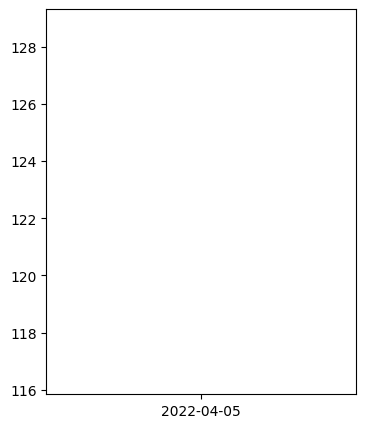

In [9]:
figure, ax = plt.subplots(figsize=(4,5))

x = np.linspace(0, 20, 80)
y = np.sin(x)
plt.ion()
plot1, = ax.plot(dates, jpy_usd_rates)
plot2, = ax.plot(dates, jpy_usd_25)
plot3, = ax.plot(dates, jpy_usd_75)

plt.show()

In [10]:
def init_rates():
  return {jpy_pair: [] for jpy_pair in JPY_PAIR_LIST}

In [22]:
def calc_exchangeRequests_goldenclosee(nextResponse):
  calc_exchangeRequests = []
  for jpy_pair in JPY_PAIR_LIST:
    rates[jpy_pair].append(nextResponse['nextDateRates'][jpy_pair])
    rates_25[jpy_pair].append(np.mean(rates[jpy_pair][-25:]))
    rates_75[jpy_pair].append(np.mean(rates[jpy_pair][-75:]))
  if len(rates['USD/JPY']) < 75:
    return calc_exchangeRequests
  for jpy_pair in JPY_PAIR_LIST:
    currency = jpy_pair[:3]
    if rates_25[jpy_pair][-1] > rates_75[jpy_pair][-1]:
      # Upper trend
      if currency not in nextResponse['currencyToBalance'] or nextResponse['currencyToBalance'][currency] == 0:
        # Doesn't have position. Buy the currency.
          calc_exchangeRequests.append({'currencyFrom': 'JPY',  'currencyTo': currency,  'amount': nextResponse['currencyToBalance']['JPY'] / len(JPY_PAIR_LIST)})
    else:
      # Downer trend
      if currency in nextResponse['currencyToBalance']:
        # Does have position. Sell the currency.
        calc_exchangeRequests.append({'currencyFrom': currency,  'currencyTo': 'JPY',  'amount': nextResponse['currencyToBalance'][currency]})
  return calc_exchangeRequests

def calc_exchangeRequests_tsumitate(nextResponse):
  calc_exchangeRequests = []
  calc_exchangeRequests.append({'currencyFrom': 'JPY',  'currencyTo': 'USD',  'amount': 100})
  return calc_exchangeRequests

In [25]:
TESTCASE = '2018-Jan-Mar-with-commission'
response = requests.post(START_URL.format(TESTCASE, USERID))
session_info = response.json()
session_id = session_info['sessionId']
is_complete = session_info['complete']

request_base = {'sessionId' : session_id, 'exchangeRequests': []}

rates = init_rates()
rates_25 = init_rates()
rates_75 = init_rates()

request = copy.deepcopy(request_base)

while not is_complete:
  response = requests.post(NEXT_URL, json=request)
  next_info = response.json()
  print(next_info)
  is_complete =  next_info['complete']
  request = copy.deepcopy(request_base)
  request['exchangeRequests'] = calc_exchangeRequests_tsumitate(next_info)



{'sessionId': 9, 'startDate': '2018-01-04', 'endDate': '2018-03-31', 'currentDate': '2018-01-05', 'jpyBalance': 1000000.0, 'currencyToBalance': {'JPY': 1000000.0, 'SGD': 0.0, 'HKD': 0.0, 'BHD': 0.0, 'KWD': 0.0, 'MXN': 0.0, 'CAD': 0.0, 'AUD': 0.0, 'NZD': 0.0, 'ZAR': 0.0, 'GBP': 0.0, 'DKK': 0.0, 'NOK': 0.0, 'SEK': 0.0, 'CHF': 0.0, 'EUR': 0.0, 'PHP': 0.0, 'SAR': 0.0, 'INR': 0.0, 'USD': 0.0, 'THB': 0.0, 'TWD': 0.0, 'IDR': 0.0, 'AED': 0.0}, 'nextDateRates': {'THB/PHP': 0.650429799426934, 'CAD/THB': 0.0386232846392209, 'HKD/SGD': 5.893970893970894, 'AUD/DKK': 0.2064996614759648, 'HKD/KWD': 25.961884961884962, 'AUD/PHP': 0.025614985330625138, 'ZAR/SEK': 1.5119825708061003, 'ZAR/BHD': 32.613289760348586, 'ZAR/PHP': 0.24727668845315906, 'CAD/NOK': 0.15482514386896856, 'AED/HKD': 0.4695737064757566, 'DKK/MXN': 0.31967213114754095, 'DKK/IDR': 0.04590163934426229, 'DKK/ZAR': 0.5016393442622951, 'USD/AED': 0.27233250620347393, 'SGD/EUR': 1.601528512639624, 'CAD/DKK': 0.20252324037184596, 'AUD/HKD':

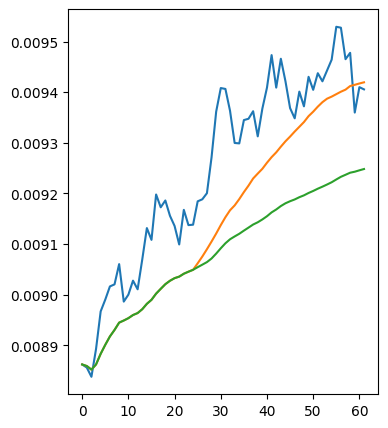

In [18]:
figure, ax = plt.subplots(figsize=(4,5))

currency = 'USD'

x = range(len(rates[currency + '/JPY']))
plt.ion()
plot1, = ax.plot(x, rates[currency + '/JPY'])
plot2, = ax.plot(x, rates_25[currency + '/JPY'])
plot3, = ax.plot(x, rates_75[currency + '/JPY'])

plt.show()

In [24]:
result = next_info['jpyBalance']
print(result)

999893.482302463
